In [6]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('..')))

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # module for progress bar (https://pypi.org/project/tqdm/)

# custom package where all models are written
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator # model
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_samples # sample generator
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_isoprob_transform

import Surrogates.PolynomialChaosExpansion as PCE
import Surrogates.KarhunenLoeveExpansion as KLE

# set seed for reproducibility 
np.random.seed(152)

# Pick and Freeze method

In [9]:
def pick_and_freeze(model,t,A,B):
    
    '''
    Point-wise first and total order Sobol Indices

    Inputs:
        model = function that returns output of model for given input
        t = time to at which model must be evaluated
        A = First set of random inputs of size [N,n]
        B = Second set of random inputs of size [N,n] 
        
    Outputs:
        S = [n,1] vector
            First-order sensitivity of each the 'n' parameters
            at time 't'. 
            
        S_T = [n,1] vector
              Total sensitivity of each the 'n' parameters
              at time 't'.
              
    '''
    n = A.shape[1] # number of variables
    N = A.shape[0] # number of MC samples
    
    def get_C_i(i):
        C_i = np.copy(B)
        C_i[:,i] = A[:,i]
        return C_i

    f_A = model(A,t).flatten() # [N,1] vector with evaluations at x_A, (flatten for broadcasting)
    f_B = model(B,t).flatten() # [N,1] vector with evaluations at x_B, (flatten for broadcasting)

    f_0 = np.mean(f_A) # scalar

    S = np.zeros((n,1))
    S_T = np.zeros((n,1)) 

    for i in range(n):
        f_C = model(get_C_i(i),t).flatten()

        # denominator is common in both terms
        # V[Y] = E[Y**2] - E[Y]**2
        total_variance = (np.dot(f_A,f_A)/N) - f_0**2
                        
        # First order indices
        S[i] = ( (np.dot(f_A,f_C)/N) - f_0**2 )  / ( total_variance )
        
        #Total indices
        S_T[i] = 1 - ( (np.dot(f_B,f_C)/N - f_0**2) ) / ( total_variance )  
        
    return S, S_T

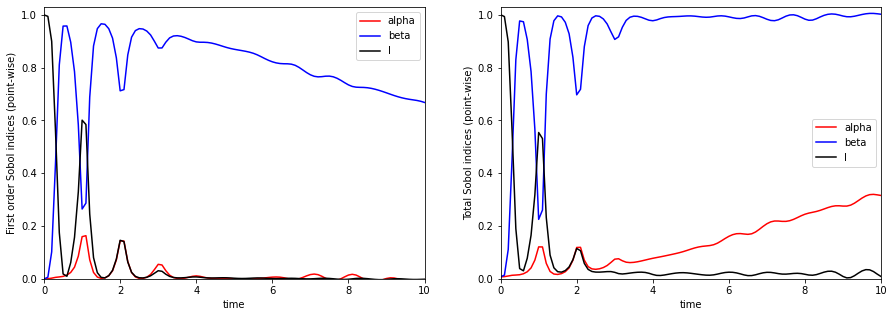

In [12]:
N = 50_000 # number of MC samples

X = mech_oscillator_samples(2*N)

A = X[:N, :]
B = X[N:, :]

# number of discretizations in time, 
# i.e divide [0,10] in n_t points
n_t = 100 +1 

# Time discretization
T = np.linspace(0, 10, n_t)

# store first order sensitivity for each parmeter for each point in time
MC_S = np.zeros((3, n_t))

# store total sensitivity for each parmeter for each point in time
MC_S_T = np.zeros((3, n_t))

for i in range(n_t):

    # compute sensitivities
    S , S_T = pick_and_freeze(mech_oscillator, T[i], A, B)  

    MC_S[:,i] = S[:,0] # store     
    MC_S_T[:,i] = S_T[:,0] # store 
        
'Plots'

fig, ax = plt.subplots(1, 2,figsize=(15,5))

ax[0].plot(T, MC_S[0,:], '-', color = 'red', label = 'alpha')
ax[0].plot(T, MC_S[1,:], '-', color = 'blue', label = 'beta')
ax[0].plot(T, MC_S[2,:], '-', color = 'black', label = 'l')
ax[0].legend()
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,1.03)
ax[0].set_xlabel('time')
ax[0].set_ylabel('First order Sobol indices (point-wise)')

ax[1].plot(T, MC_S_T[0,:], '-', color = 'red', label = 'alpha')
ax[1].plot(T, MC_S_T[1,:], '-', color = 'blue', label = 'beta')
ax[1].plot(T, MC_S_T[2,:], '-', color = 'black', label = 'l')
ax[1].legend()
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,1.03)
ax[1].set_xlabel('time')
ax[1].set_ylabel('Total Sobol indices (point-wise)')

plt.show()

# PCE Surrogate

In [13]:
# PCE Surrogate
total_polynomial_degree = 7
number_of_random_variables = N_p = 3
polynomial_classes_of_random_variables = [PCE.Legendre]*number_of_random_variables

PCE_t_i = PCE.PCE_surrogate(total_polynomial_degree, polynomial_classes_of_random_variables, mech_oscillator_isoprob_transform)

N = 10_000 # number of 'instances'/'realisations'
X = mech_oscillator_samples(N)
Y = mech_oscillator(X,T)
n_t = 100 + 1

# Points where Sobol indices must be computed
T = np.linspace(0, 10, n_t) # row vector

# store indices
PCE_S = np.zeros((N_p, n_t))
PCE_S_T = np.zeros((N_p, n_t))

# store LOO error
LOO_error = np.zeros((n_t, 1))

for j, _ in enumerate(tqdm(T, desc = 'Computing Indices', ncols=100)):

    X_hat = X
    Y_hat = Y.T[j, :]

    _ = PCE_t_i.find_coefficients(X_hat, Y_hat)

    # store error at each t_i
    LOO_error[j] = PCE_t_i.LeaveOneOut(X_hat, Y_hat)

    # Sobol Indices
    S_first, S_tot = PCE_t_i.Sobol_Indices()

    PCE_S[:, j] = S_first
    PCE_S_T[:, j] = S_tot

Computing Indices: 100%|██████████████████████████████████████████| 101/101 [01:02<00:00,  1.62it/s]


# Plot

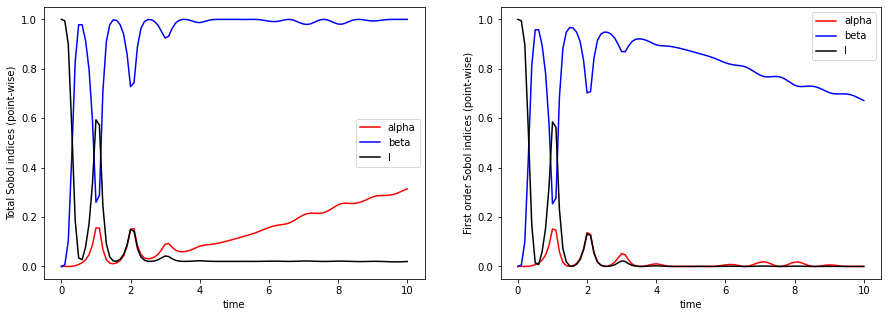

In [14]:
fig, ax = plt.subplots(1, 2,figsize=(15,5))

ax[0].plot(T, PCE_S_T[0,:], '-', color = 'red', label = 'alpha')
ax[0].plot(T, PCE_S_T[1,:], '-', color = 'blue', label = 'beta')
ax[0].plot(T, PCE_S_T[2,:], '-', color = 'black', label = 'l')
ax[0].legend()
ax[0].set_xlabel('time')
ax[0].set_ylabel('Total Sobol indices (point-wise)')

ax[1].plot(T, PCE_S[0,:], '-', color = 'red', label = 'alpha')
ax[1].plot(T, PCE_S[1,:], '-', color = 'blue', label = 'beta')
ax[1].plot(T, PCE_S[2,:], '-', color = 'black', label = 'l')
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('First order Sobol indices (point-wise)')

plt.show()

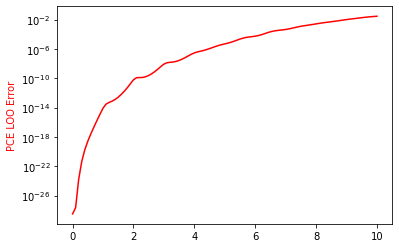

0.03011757353548198


In [15]:
fig, ax = plt.subplots()

ax.semilogy(T, LOO_error, color = 'red', label = 'PCE LOO Error')
ax.set_ylabel("PCE LOO Error", color = 'red')

plt.show()

print(np.max(LOO_error))

In [17]:
N = 10_000 # number of 'instances'/'realisations'

n_t = 101

t = np.linspace(0, 10, n_t) # row vector
T = np.tile(t, (N, 1)) # repeat row 't' along axis 0

SampleSpace = mech_oscillator_samples(N) # generate samples

Y = mech_oscillator(SampleSpace, T) # compute output (displacement) [N, n_t]

Variance quantified by 10 terms = 0.9999954379575814


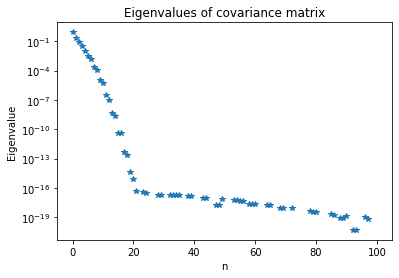

Number of PCE terms: 286
Number of evaluations needed (empirical estimate): 572
Number of function evaluations: 10000


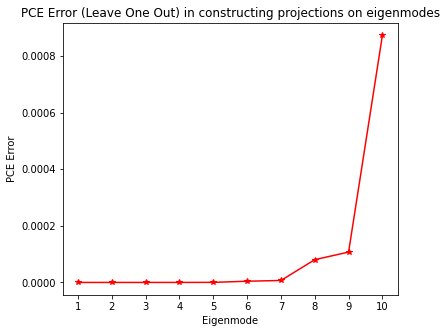

In [18]:
total_polynomial_degree = 10
number_of_random_variables = 3
polynomial_classes_of_random_variables = ['Legendre']*number_of_random_variables

# truncation level for KLE
n_kl = 10

test = KLE.KLE(SampleSpace, Y, t, total_polynomial_degree, n_kl, 
                polynomial_classes_of_random_variables, mech_oscillator_isoprob_transform, PCE_error_flag = True)

# test.plot_eigenvectors() # only even n_kl
# test.plot_projections() # only even n_kl

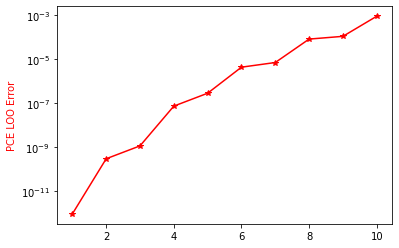

0.001072589453272505


In [28]:
fig, ax = plt.subplots()

ax.semilogy(np.linspace(1, n_kl, n_kl), test.PCE_errors, '-*', color = 'red', label = 'PCE LOO Error')
ax.set_ylabel("PCE LOO Error", color = 'red')

plt.show()

print(np.max(test.PCE_errors))

# Sobol Indices

Using Pick and Freeze method

In [29]:
def pick_and_freeze(model, I, N, N_p, A, B):
    """
    Point-wise first and total order Sobol Indices

    Inputs:
        model = function that returns output of model for given input
                Input:  ndarray
                        [N, N_p]
                Output: [n_t, N]
                        Model evaluations for desired set of parameters
                        Each column has ouput of 1 set of parameters
        I = list or 1D array
            Indices in solution at which Sobol indices must be computed
        N = int
            number of MC samples
        N_p = int
              number of parameters
        A = ndarray
            First set of random inputs of size [N, N_p]
        B = ndarray
            Second set of random inputs of size [N, N_p]
        
    Outputs:
        S = ndarray
            [n, num_of_points] 
            num_of_points = len(num_of_points)
            First-order sensitivity of each the 'n' parameters
            at each I 

        S_T = ndarray
              [n,1]
              num_of_points = len(num_of_points)
              Total sensitivity of each the 'n' parameters
              at each I
    """

    def get_C_i(i):
        C_i = np.copy(B)
        C_i[:,i] = A[:,i]
        return C_i

    f_A = model(A) # [n_t, N] vector with evaluations at x_A
    f_B = model(B) # [n_t, N] vector with evaluations at x_B

    # store f_C
    f_C = np.zeros((f_A.shape[0], f_A.shape[1], N_p)) # [n_t, N, N_p] 3d array with evaluations at x_C_i

    for i in tqdm(range(N_p), desc = 'Computing f_C', ncols=100):
        f_C[:, :, i] = model(get_C_i(i)) # [n_t, N] vector with evaluations at x_C_i

    f_0 = np.mean(f_A, axis=1) # [n_t, 1] mean over N realisation for each discretisation point

    num_of_points = len(I)

    S = np.zeros((N_p, num_of_points))
    S_T = np.zeros((N_p, num_of_points))

    for j, time_index in enumerate(tqdm(I, desc = 'Computing Indices', ncols=100)):

        for i in range(N_p):
            f_A_local = f_A[time_index, :].T # [N, 1] vector
            f_B_local = f_B[time_index, :].T # [N, 1] vector
            f_C_local = f_C[time_index, :, i].T # [N, 1] vector
            f_0_local = f_0[time_index]

            # denominator is common in both terms
            # V[Y] = E[Y**2] - E[Y]**2
            total_variance = (np.dot(f_A_local, f_A_local)/N) - f_0_local**2

            # First order indices
            # Each column contains indices corresponding to a point in I
            S[i, j] = ( (np.dot(f_A_local, f_C_local)/N) - f_0_local**2 )  / ( total_variance )

            # Total indices
            # Each column contains indices corresponding to a point in I
            S_T[i, j] = 1 - ( (np.dot(f_B_local, f_C_local)/N - f_0_local**2) ) / ( total_variance )  

    return S, S_T

In [30]:
def mech_oscillator_wrapper(parameters):

    return test.surrogate_evaluate(parameters).T

Total number of function evalutions = 250000


Computing Indices: 100%|████████████████████████████████████████| 101/101 [00:00<00:00, 4214.88it/s]


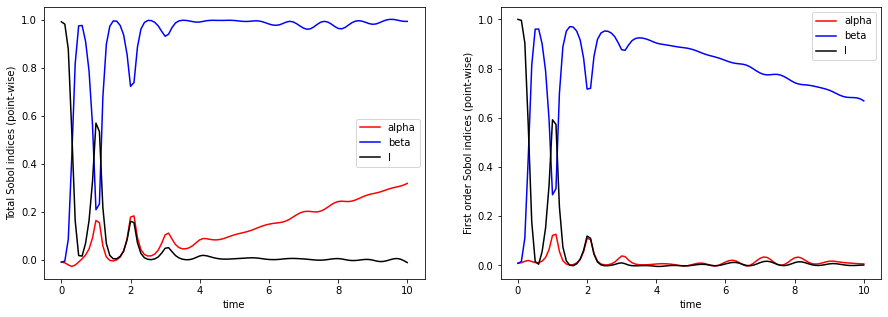

In [31]:
N = 50_000 # number of MC samples

X = mech_oscillator_samples(2*N)

A = X[:N, :]
B = X[N:, :]

n_t = 100  # discretization in time
T = np.linspace(0, 10, n_t+1) # row vector

inspection_points = 101

I = np.linspace(0 , n_t, inspection_points, dtype=int)

print(f'Total number of function evalutions = {N*(3+2)}')

KLE_S, KLE_S_T = pick_and_freeze(mech_oscillator_wrapper, I, N, 3, A, B)

'Plots'

fig, ax = plt.subplots(1, 2,figsize=(15,5))

ax[0].plot(T, KLE_S_T[0,:], '-', color = 'red', label = 'alpha')
ax[0].plot(T, KLE_S_T[1,:], '-', color = 'blue', label = 'beta')
ax[0].plot(T, KLE_S_T[2,:], '-', color = 'black', label = 'l')
ax[0].legend()
ax[0].set_xlabel('time')
ax[0].set_ylabel('Total Sobol indices (point-wise)')

ax[1].plot(T, KLE_S[0,:], '-', color = 'red', label = 'alpha')
ax[1].plot(T, KLE_S[1,:], '-', color = 'blue', label = 'beta')
ax[1].plot(T, KLE_S[2,:], '-', color = 'black', label = 'l')
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('First order Sobol indices (point-wise)')

plt.show()

# Compare First Order Indices

[]

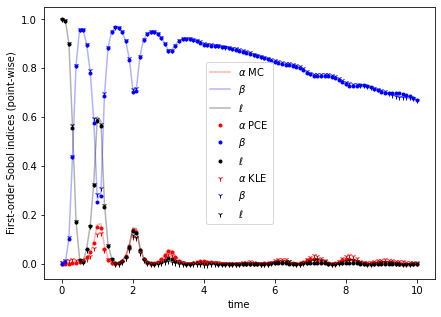

In [37]:
fig, ax = plt.subplots(1, 1,figsize=(7,5))

ax.plot(T, MC_S[0,:], '-', alpha = 0.3, color = 'red',   label = r'$\alpha$ MC')
ax.plot(T, MC_S[1,:], '-', alpha = 0.3, color = 'blue',  label = r'$\beta$')
ax.plot(T, MC_S[2,:], '-', alpha = 0.3, color = 'black', label = r'$\ell$')

ax.plot(T, PCE_S[0,:], '.', color = 'red',   label = r'$\alpha$ PCE')
ax.plot(T, PCE_S[1,:], '.', color = 'blue',  label = r'$\beta$')
ax.plot(T, PCE_S[2,:], '.', color = 'black', label = r'$\ell$')

ax.plot(T, KLE_S[0,:], '1', color = 'red',   label = r'$\alpha$ KLE')
ax.plot(T, KLE_S[1,:], '1', color = 'blue',  label = r'$\beta$')
ax.plot(T, KLE_S[2,:], '1', color = 'black', label = r'$\ell$')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('First-order Sobol indices')

plt.plot()

# Compare Total Order Indices

[]

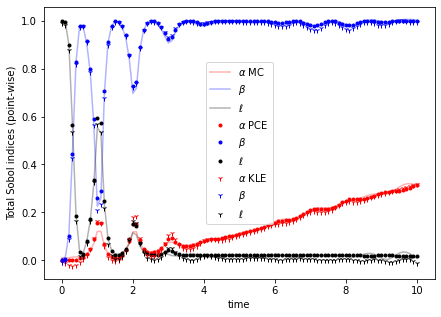

In [36]:
fig, ax = plt.subplots(1, 1,figsize=(7,5))

ax.plot(T, MC_S_T[0,:], '-', alpha = 0.3, color = 'red',   label = r'$\alpha$ MC')
ax.plot(T, MC_S_T[1,:], '-', alpha = 0.3, color = 'blue',  label = r'$\beta$')
ax.plot(T, MC_S_T[2,:], '-', alpha = 0.3, color = 'black', label = r'$\ell$')

ax.plot(T, PCE_S_T[0,:], '.', color = 'red',   label = r'$\alpha$ PCE')
ax.plot(T, PCE_S_T[1,:], '.', color = 'blue',  label = r'$\beta$')
ax.plot(T, PCE_S_T[2,:], '.', color = 'black', label = r'$\ell$')

ax.plot(T, KLE_S_T[0,:], '1', color = 'red',   label = r'$\alpha$ KLE')
ax.plot(T, KLE_S_T[1,:], '1', color = 'blue',  label = r'$\beta$')
ax.plot(T, KLE_S_T[2,:], '1', color = 'black', label = r'$\ell$')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('Total-order Sobol indices')

plt.plot()